<a href="https://colab.research.google.com/github/letsgo247/Deep-Learning-Study/blob/master/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#작은 데이터셋으로 강력한 이미지 분류 모델 설계하기

https://keraskorea.github.io/posts/2018-10-24-little_data_powerful_model/

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#used-in-the-notebooks_1

https://tykimos.github.io/2017/06/10/CNN_Data_Augmentation/

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# datagen = ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         shear_range=0.2,
#         zoom_range=0.1,
#         horizontal_flip=True,
#         fill_mode='constant')   #'nearest':끝의 cell로 채우기, 'constant':걍 검은색, 'reflact':거울상, 'wrap':반복 채우기

# img = load_img('/content/data/Osstem/김달원_#44,46.jpg')  # PIL 이미지
# x = img_to_array(img)  # (3, 150, 150) 크기의 NumPy 배열
# x = x.reshape((1,) + x.shape)  # (1, 3, 150, 150) 크기의 NumPy 배열

# # 아래 .flow() 함수는 임의 변환된 이미지를 배치 단위로 생성해서
# # 지정된 `preview/` 폴더에 저장합니다.
# i = 0
# for batch in datagen.flow(x, batch_size=1,
#                           save_to_dir='/content/data/Osstem/preview3', save_prefix='osstem', save_format='jpeg'):
#     i += 1
#     if i > 20:
#         break  # 이미지 20장을 생성하고 마칩니다

In [102]:
from keras.models import *
from keras.layers import *

model = Sequential()
# model.add(Conv2D(32, (3, 3), input_shape=(3, 150, 150), data_format='channels_first'))
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # 이전 CNN 레이어에서 나온 3차원 배열은 1차원으로 뽑아줍니다
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [103]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16

# 학습 이미지에 적용한 augmentation 인자를 지정해줍니다.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# 검증 및 테스트 이미지는 augmentation을 적용하지 않습니다. 모델 성능을 평가할 때에는 이미지 원본을 사용합니다.
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지를 배치 단위로 불러와 줄 generator입니다.
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/dogs-vs-cats/train',  # this is the target directory
        target_size=(150, 150),  # 모든 이미지의 크기가 150x150로 조정됩니다.
        batch_size=batch_size,
        class_mode='binary')  # binary_crossentropy 손실 함수를 사용하므로 binary 형태로 라벨을 불러와야 합니다.

validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/dogs-vs-cats/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/dogs-vs-cats/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [89]:
import numpy as np
print(train_generator[1][0].shape)
print(train_generator[1][1].shape)
train_generator[0][1]

(16, 150, 150, 3)
(16, 2)


array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [117]:
#Categorical
import time

t_s = time.time()

hist = model.fit_generator(
        train_generator,
        steps_per_epoch=1000 // batch_size,
        validation_data=validation_generator,
        epochs=3)
model.save_weights('first_try.h5')  # 많은 시간을 들여 학습한 모델인 만큼, 학습 후에는 꼭 모델을 저장해줍시다.

t_e = time.time()
t = t_e - t_s
print(t/60+'m')

Epoch 1/3
62/62 [==============================] - 13s 209ms/step - loss: 0.3913 - accuracy: 0.8256 - val_loss: 0.6410 - val_accuracy: 0.7837
Epoch 2/3
62/62 [==============================] - 11s 175ms/step - loss: 0.4115 - accuracy: 0.8135 - val_loss: 0.3910 - val_accuracy: 0.7675
Epoch 3/3
62/62 [==============================] - 13s 204ms/step - loss: 0.4296 - accuracy: 0.8196 - val_loss: 0.7043 - val_accuracy: 0.7625
0.6079301317532857


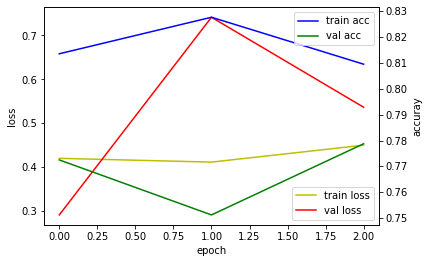

In [116]:
#그래프 그려주는 모듈

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots() 

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
# loss_ax.set_ylim([0.0, 2])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
# acc_ax.set_ylim([0.5, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='lower right')
acc_ax.legend(loc='upper right')

In [106]:
#Binary

model.fit_generator(
        train_generator,
        steps_per_epoch=1000 // batch_size,
        validation_data=validation_generator,
        epochs=50)
model.save_weights('first_try(binary).h5')  # 많은 시간을 들여 학습한 모델인 만큼, 학습 후에는 꼭 모델을 저장해줍시다.

Epoch 1/50
62/62 [==============================] - 14s 225ms/step - loss: 0.6937 - accuracy: 0.5302 - val_loss: 0.6726 - val_accuracy: 0.5838
Epoch 2/50
62/62 [==============================] - 11s 185ms/step - loss: 0.6898 - accuracy: 0.5625 - val_loss: 0.5766 - val_accuracy: 0.6350
Epoch 3/50
62/62 [==============================] - 14s 223ms/step - loss: 0.6592 - accuracy: 0.6099 - val_loss: 0.5355 - val_accuracy: 0.6463
Epoch 4/50
62/62 [==============================] - 12s 186ms/step - loss: 0.6796 - accuracy: 0.6190 - val_loss: 0.7968 - val_accuracy: 0.5750
Epoch 5/50
62/62 [==============================] - 14s 219ms/step - loss: 0.6338 - accuracy: 0.6381 - val_loss: 0.5516 - val_accuracy: 0.6625
Epoch 6/50
62/62 [==============================] - 12s 187ms/step - loss: 0.6285 - accuracy: 0.6573 - val_loss: 0.6280 - val_accuracy: 0.6750
Epoch 7/50
62/62 [==============================] - 13s 215ms/step - loss: 0.6133 - accuracy: 0.6613 - val_loss: 0.7538 - val_accuracy: 0.6900